# First Architecture

This is a simple perceptron architecture with only one layer.

In [24]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

## Load Data

In [2]:
df_train = pd.read_csv('data/raw/lithology.csv', sep=';')
df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,24.735691,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,24.492376,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,24.202299,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,24.400797,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,24.916765,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68


In [3]:
def lithology_number_to_name(x):
    if x == 30000.0:
        return 'Sandstone'
    elif x == 65030.0:
        return 'Sandstone/Shale'
    elif x == 65000.0:
        return 'Shale'
    elif x == 80000.0:
        return 'Marl'
    elif x == 74000.0:
        return 'Dolomite'
    elif x == 70000.0:
        return 'Limestone'
    elif x == 70032.0:
        return 'Chalk'
    elif x == 88000.0:
        return 'Halite'
    elif x == 86000.0:
        return 'Anhydrite'
    elif x == 99000.0:
        return 'Tuff'
    elif x == 90000.0:
        return 'Coal'
    elif x == 93000.0:
        return 'Basement'
    else: raise ValueError('Category Not Found')

df_train = df_train.assign(FORCE_2020_LITHOFACIES_LITHOLOGY_CAT = df_train.FORCE_2020_LITHOFACIES_LITHOLOGY.apply(lambda x: lithology_number_to_name(x)))

df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded,FORCE_2020_LITHOFACIES_LITHOLOGY_CAT
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Shale
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68,Shale
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68,Shale
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68,Shale
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68,Shale


In [4]:
df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Shale              720803
Sandstone          168937
Sandstone/Shale    150455
Limestone           56320
Marl                33329
Tuff                15245
Chalk               10513
Halite               8213
Coal                 3820
Dolomite             1688
Anhydrite            1085
Basement              103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

In [5]:
def get_values_from_category(df_train, n_samples=1000):
    '''
    Get the same values (or all if it has less than) of all categories. The idea is to balance dataset
    '''

    df_data = pd.DataFrame()

    for cat in df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.unique():
        df_data = df_data.append(df_train[df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT == cat].iloc[0:n_samples])
    
    return df_data

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

def transform_data(X_train, X_test, X_val, y_train, y_test, y_val):
    std = StandardScaler()
    oe = OrdinalEncoder()

    X_train_transform = std.fit_transform(X_train)
    X_test_transform = std.transform(X_test)
    X_val_transform = std.transform(X_val)

    y_train_enc = oe.fit_transform(y_train)
    y_test_enc = oe.transform(y_test)
    y_val_enc = oe.transform(y_val)

    return X_train_transform, X_test_transform, X_val_transform, y_train_enc, y_test_enc, y_val_enc

In [7]:
def get_class_distribution(obj):
    count_dict = {
        'Anhydrite': 0, 
        'Basement': 0, 
        'Chalk': 0, 
        'Coal': 0, 
        'Dolomite': 0, 
        'Halite': 0,
        'Limestone': 0, 
        'Marl': 0, 
        'Sandstone': 0, 
        'Sandstone/Shale': 0, 
        'Shale': 0,
        'Tuff': 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Anhydrite'] += 1
        elif i == 1: 
            count_dict['Basement'] += 1
        elif i == 2: 
            count_dict['Chalk'] += 1
        elif i == 3: 
            count_dict['Coal'] += 1
        elif i == 4: 
            count_dict['Dolomite'] += 1  
        elif i == 5: 
            count_dict['Halite'] += 1
        elif i == 6: 
            count_dict['Limestone'] += 1                    
        elif i == 7: 
            count_dict['Marl'] += 1
        elif i == 8: 
            count_dict['Sandstone'] += 1
        elif i == 9: 
            count_dict['Sandstone/Shale'] += 1
        elif i == 10: 
            count_dict['Shale'] += 1
        elif i == 11: 
            count_dict['Tuff'] += 1
        else:
            print("Check classes.")
            
    return count_dict

### Models Loaded

In [36]:
class SingleLayerSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(SingleLayerSoftmax, self).__init__()
        self.Linear = nn.Linear(n_input, n_output)
    
    def forward(self, x):
        return self.Linear(x)

In [37]:
def load_model(model_name, num_features, num_classes):
    if model_name == 'single_layer':
        return SingleLayerSoftmax(num_features, num_classes)

### Creating a simple model

Model created thanks to this documentation: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [55]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)

def fit_model(
    X_train, y_train, X_test, y_test, X_val, y_val, 
    epochs=5, batch_size=16, num_classes=12, learning_rate=0.05,
    model_name='single_layer'
):
    NUM_FEATURES = len(X.columns)
    NUM_CLASSES = 12

    train_dataset = ClassifierDataset(
        torch.from_numpy(X_train.astype(np.float32)), 
        torch.from_numpy(y_train.reshape(-1)).long()
    )

    val_dataset = ClassifierDataset(
        torch.from_numpy(X_val.astype(np.float32)), 
        torch.from_numpy(y_val.reshape(-1)).long()
    )

    test_dataset = ClassifierDataset(
        torch.from_numpy(X_test.astype(np.float32)), 
        torch.from_numpy(y_test.reshape(-1)).long()
    )

    target_list = []
    for _, t in train_dataset:
        target_list.append(t)

    target_list = torch.tensor(target_list)
    target_list = target_list[torch.randperm(len(target_list))]

    # Due to unbalanced data, create weights to classes
    class_count = [i for i in get_class_distribution(y_train).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float)

    class_weights_all = class_weights[target_list]
    weighted_sampler = WeightedRandomSampler(
        weights=class_weights_all,
        num_samples=len(class_weights_all),
        replacement=True
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        sampler=weighted_sampler
    )

    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    # model = SingleLayerSoftmax(NUM_FEATURES, NUM_CLASSES)
    model = load_model(model_name, NUM_FEATURES, NUM_CLASSES)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(model)

    accuracy_stats = {
        'train': [],
        'val': []
    }

    loss_stats = {
        'train': [],
        'val': []
    }

    print('Begin training')

    # Using tqdm to show the loading
    for e in tqdm(range(1, epochs+1)):
        # Training
        train_epoch_loss = 0
        train_epoch_acc = 0

        model.train()
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
        
        # Validation
        with torch.no_grad():
            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for X_val_batch, y_val_batch in val_loader:

                y_val_pred = model(X_val_batch)
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
        
        train_loss = train_epoch_loss/len(train_loader)
        val_loss = val_epoch_loss/len(val_loader)

        train_acc = train_epoch_acc/len(train_loader)
        val_acc = val_epoch_acc/len(val_loader)

        loss_stats['train'].append(train_loss)
        loss_stats['val'].append(val_loss)
        accuracy_stats['train'].append(train_acc)
        accuracy_stats['val'].append(val_acc)
        print(f'''Epoch {e+0:03}: | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | 
        Train Acc: {train_acc:.3f}% | Val Acc: {val_acc:.3f}%''')

    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index": "epochs"})

    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index": "epochs"})

    # Plotting Accuracy and Loss
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x='epochs', y='value', hue='variable', ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x='epochs', y='value', hue='variable', ax=axes[1]).set_title('Train-Val Loss/Epoch')

    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim=1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    idx2class = {
        0: 'Anhydrite', 
        1: 'Basement', 
        2: 'Chalk', 
        3: 'Coal', 
        4: 'Dolomite', 
        5: 'Halite',
        6: 'Limestone', 
        7: 'Marl', 
        8: 'Sandstone', 
        9: 'Sandstone/Shale', 
        10: 'Shale',
        11: 'Tuff'
    }

    # Confusion Matrix
    ax = plt.subplot()
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
    sns.heatmap(confusion_matrix_df, annot=True, fmt='g', ax=ax)

    print(classification_report(y_test, y_pred_list))


### Test 1 - 10000 samples, 1000 epochs, Single Layer

Tuff               10000
Limestone          10000
Chalk              10000
Sandstone/Shale    10000
Shale              10000
Sandstone          10000
Marl               10000
Halite              8213
Coal                3820
Dolomite            1688
Anhydrite           1085
Basement             103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
SingleLayerSoftmax(
  (Linear): Linear(in_features=30, out_features=12, bias=True)
)
Begin training


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.14763 | Val Loss: 0.88383 | 
        Train Acc: 69.056% | Val Acc: 74.533%
              precision    recall  f1-score   support

         0.0       0.46      0.74      0.57       217
         1.0       0.76      0.95      0.84        20
         2.0       0.86      0.73      0.79      2000
         3.0       0.83      0.83      0.83       764
         4.0       0.40      0.34      0.36       338
         5.0       0.97      0.96      0.97      1643
         6.0       0.60      0.80      0.69      2000
         7.0       0.74      0.62      0.68      2000
         8.0       0.68      0.67      0.67      2000
         9.0       0.65      0.62      0.63      2000
        10.0       0.81      0.92      0.86      2000
        11.0       0.84      0.72      0.77      2000

    accuracy                           0.75     16982
   macro avg       0.72      0.74      0.72     16982
weighted avg       0.76      0.75      0.75     16982



,Anhydrite,Basement,Chalk,Coal,Dolomite,Halite,Limestone,Marl,Sandstone,Sandstone/Shale,Shale,Tuff
Anhydrite,160,0,10,1,1,35,8,2,0,0,0,0
Basement,0,19,0,0,1,0,0,0,0,0,0,0
Chalk,0,0,1463,0,0,0,472,4,20,25,1,15
Coal,0,0,0,632,41,0,0,3,43,2,3,40
Dolomite,52,1,0,31,114,4,24,24,3,9,0,76
Halite,40,0,25,0,0,1574,1,0,0,3,0,0
Limestone,54,0,6,0,5,2,1609,86,66,55,71,46
Marl,17,0,102,8,44,1,276,1246,15,186,12,93
Sandstone,1,1,2,0,0,0,226,6,1342,243,176,3
Sandstone/Shale,21,4,29,0,19,0,34,170,323,1237,153,10


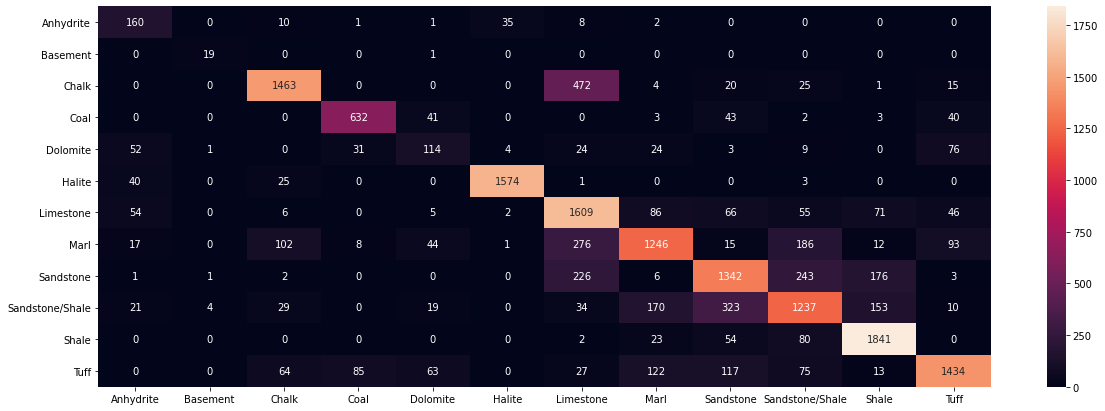

In [54]:
df_partial_data = get_values_from_category(df_train, n_samples=10000)
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
    'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
    'MUDWEIGHT', 'RMIC', 'Carbon_Index',
    'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
    'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
    'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

#Dataset division: 70:20:10
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.1,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

fit_model(
    X_train_transform, y_train_transform, X_test_transform, y_test_transform, X_val_transform, y_val_transform, 
    epochs=1000, batch_size=16, num_classes=12, learning_rate=0.01,
    model_name='single_layer'
)